### Download NASA ICESat-2 ATL 11 Data

Data downloaded via: https://github.com/nsidc/earthaccess

In [2]:
#import dependencies
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray 
import pprint
import h5py
from pathlib import Path
from datetime import datetime
import pandas as pd

In [3]:
#log in to Earthdata
earthaccess.login(strategy= "interactive", persist= True)

Enter your Earthdata Login username:  adhoward123
Enter your Earthdata password:  ········


In [4]:
#searching data
    # for preliminary exploration, focus on data from Lake Vostok - stable subglacial lake 
    # Lake Vostok - 77.5 S, 106.0 E
granules  = earthaccess.search_data(
    short_name='ATL11',  # ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height 
    bounding_box=(105.0, -78.5, 107.0, -76.5),  
    temporal=("2019-04-01", "2025-04-01"),
)

len(granules)

87

In [5]:
data_dir = Path("C:/Users/Ashley Howard/OneDrive - UW/Desktop/MLGEO_Sublacial_Lakes/ATL11_LakeVostok/")
earthaccess.download(granules, local_path=data_dir) #commented out to avoid re-downloading files

QUEUEING TASKS | :   0%|          | 0/87 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/87 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/87 [00:00<?, ?it/s]

[WindowsPath('C:/Users/Ashley Howard/OneDrive - UW/Desktop/MLGEO_Sublacial_Lakes/ATL11_LakeVostok/ATL11_000310_0326_006_12.h5'),
 WindowsPath('C:/Users/Ashley Howard/OneDrive - UW/Desktop/MLGEO_Sublacial_Lakes/ATL11_LakeVostok/ATL11_000310_0328_007_01.h5'),
 WindowsPath('C:/Users/Ashley Howard/OneDrive - UW/Desktop/MLGEO_Sublacial_Lakes/ATL11_LakeVostok/ATL11_000310_0329_007_02.h5'),
 WindowsPath('C:/Users/Ashley Howard/OneDrive - UW/Desktop/MLGEO_Sublacial_Lakes/ATL11_LakeVostok/ATL11_005712_0326_006_12.h5'),
 WindowsPath('C:/Users/Ashley Howard/OneDrive - UW/Desktop/MLGEO_Sublacial_Lakes/ATL11_LakeVostok/ATL11_005712_0328_007_01.h5'),
 WindowsPath('C:/Users/Ashley Howard/OneDrive - UW/Desktop/MLGEO_Sublacial_Lakes/ATL11_LakeVostok/ATL11_005712_0329_007_02.h5'),
 WindowsPath('C:/Users/Ashley Howard/OneDrive - UW/Desktop/MLGEO_Sublacial_Lakes/ATL11_LakeVostok/ATL11_006410_0326_006_12.h5'),
 WindowsPath('C:/Users/Ashley Howard/OneDrive - UW/Desktop/MLGEO_Sublacial_Lakes/ATL11_LakeVostok

#### ATL11 File Contents

In [5]:
atl11 = sorted(list(data_dir.glob("*.h5")))

#inspect one of the downloaded files --> top level keys
with h5py.File(atl11[0], "r") as f:
    print("keys:", list(f.keys()))

#inspect one of the pt groups --> next level
with h5py.File(atl11[0], "r") as f:
    pt1 = f["pt1"]
    print("pt1 keys:", list(pt1.keys()))

    # each pt group has the same subgroups, we want: h_corr, delta_time, latitude, longitude (maybe quality summary, and ref poiint) - need to extract

#inspect a specfic set within the pt. group --> next level 
with h5py.File(atl11[0], "r") as f:
    h = f["pt1"]["h_corr"]
    print("shape:", h.shape)


keys: ['METADATA', 'ancillary_data', 'orbit_info', 'pt1', 'pt2', 'pt3', 'quality_assessment']
pt1 keys: ['crossing_track_data', 'cycle_number', 'cycle_stats', 'delta_time', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'ref_surf']
shape: (25430, 24)


In [8]:
ATLAS_EPOCH = pd.Timestamp("2018-01-01")

def extract_atl11(h5_file, beam="pt1"):
    """
    Extract ATL11 elevation time series from beam ("pt1") into a DF
    """

    rows = []

    with h5py.File(h5_file, "r") as f:
        pt = f[beam]

        h_corr = pt["h_corr"][:]
        delta_time = pt["delta_time"][:]
        quality = pt["quality_summary"][:]

        lat = pt["latitude"][:]
        lon = pt["longitude"][:]
        ref_pt = pt["ref_pt"][:]

        n_ref, n_cycle = h_corr.shape

        for i in range(n_ref):
            for j in range(n_cycle):

                h = h_corr[i, j]
                if not np.isfinite(h):
                    continue

                dt = delta_time[i, j]
                if (not np.isfinite(dt)) or (dt > 1e20):
                    continue

                q = quality[i, j] if quality.ndim == 2 else quality[i]
                if q != 0:
                    continue

                rows.append({
                    "ref_pt": ref_pt[i],
                    "time": ATLAS_EPOCH + pd.to_timedelta(dt, unit="s"),
                    "lat": lat[i],
                    "lon": lon[i],
                    "h_corr": h,
                })

    return pd.DataFrame(rows)


In [9]:
dfs = []

for file in atl11:
    for beam in ["pt1", "pt2", "pt3"]:
        df = extract_atl11(file, beam)
        dfs.append(df)

atl11_df = pd.concat(dfs, ignore_index=True)

### Downloading (kinda) Processed ATL11 Data

In [26]:
processed_dir = data_dir / "processed"
processed_dir.mkdir(exist_ok=True)

out = processed_dir / "atl11_lakevostok.csv"
atl11_df.to_csv(out, index=False)


In [27]:
atl11_df = pd.read_csv(out)


In [28]:
atl11_df

,ref_pt,time,lat,lon,h_corr
0,1367244,2021-09-22 16:30:43.093664810,-65.525353,112.237583,-20.057898
1,1367244,2022-09-20 23:10:20.401279658,-65.525353,112.237583,-19.827234
2,1367247,2021-03-25 01:10:53.972455382,-65.525881,112.237638,-21.136070
3,1367247,2021-09-22 16:30:43.097912103,-65.525881,112.237638,-20.058670
4,1367247,2021-12-22 12:10:37.085536435,-65.525881,112.237638,-20.910269
...,...,...,...,...,...
94586798,1443555,2024-03-14 21:19:21.929842472,-78.993143,105.971512,3445.146700
94586799,1443555,2024-09-12 12:38:55.517524420,-78.993143,105.971512,3445.151100
94586800,1443555,2024-12-12 08:18:19.355849534,-78.993143,105.971512,3445.111300
94586801,1443555,2025-03-13 03:58:15.384060562,-78.993143,105.971512,3445.194600


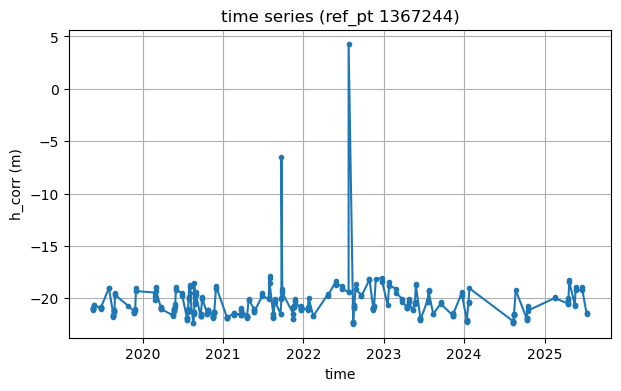

In [ ]:
#visualise elevation time series at one ref_point
point = atl11_df["ref_pt"].iloc[0] #take first value of ref_point
sub = atl11_df[atl11_df["ref_pt"] == point].sort_values("time") #used CoPilot for this line - need to ref this in an .md

plt.figure(figsize=(7,4))
plt.plot(sub["time"], sub["h_corr"], marker="o", markersize=3)
plt.xlabel("time")
plt.ylabel("h_corr (m)")
plt.title(f"time series (ref_pt {point})")
plt.grid(True)
plt.show()

#big spikes indicate subglacial lake acitivity - filling!

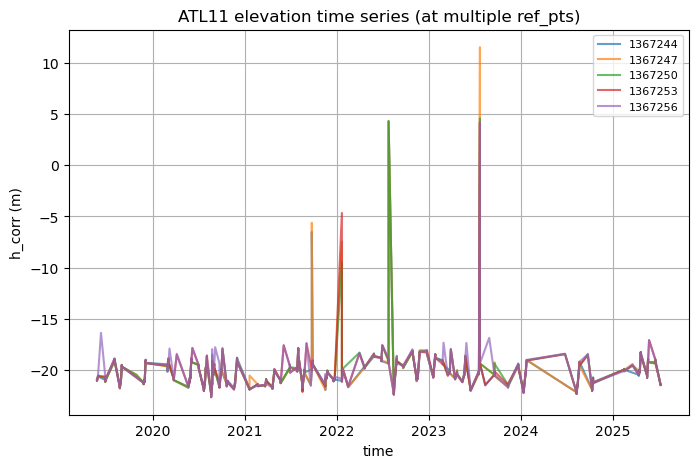

In [25]:
# random reference points
ref_pts = atl11_df["ref_pt"].unique()[:5]

plt.figure(figsize=(8,5))

for rp in ref_pts:
    sub = atl11_df[atl11_df["ref_pt"] == rp].sort_values("time")
    plt.plot(sub["time"], sub["h_corr"], alpha=0.7, label=f"{rp}")

plt.xlabel("time")
plt.ylabel("h_corr (m)")
plt.title("ATL11 elevation time series (at multiple ref_pts)")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

In [ ]:
#need to detrend